In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.interpolate import interp1d
from scipy.special import expit
from fractions import Fraction
from empiricaldist import Pmf, Cdf
import matplotlib.pyplot as plt
from collections import Counter
import statsmodels.formula.api as smfa

In [2]:
from data.utils import weibull_dist, make_uniform, make_joint, normalize, update_weibull, plot_contour, plot_lifelines, joint_weibull_mean
from data.utils import make_binomial, make_mixture

In [3]:
lam = 3
k = 0.8
# 책에서는 ss.weibull_min()을 기반하여 새로 함수를 만들었는데, 굳이 새로 만들 필요 없을듯?
# 만든 weibull_dist 대신 ss.weibull_min(k, scale=lam) 활용
actual_dist = ss.weibull_min(k, scale=lam)
data = actual_dist.rvs(10)
data

array([10.36473302,  3.70469463,  0.0945789 ,  0.55446506,  1.64430122,
        0.15146922,  0.01429561,  4.71309282,  2.08518422,  3.06893012])

In [4]:
lams = np.linspace(0.1, 10.1, 101)
ks = np.linspace(0.1, 5.1, 101)
prior_lam = make_uniform(lams, name='lambda')
prior_k = make_uniform(ks, name='k')
prior = make_joint(prior_lam, prior_k)
prior

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,...,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0,10.1
0.10,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.15,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.20,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.25,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
0.30,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.90,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
4.95,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.00,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
5.05,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098


In [5]:
lam_mesh, k_mesh, data_mesh = np.meshgrid(prior.columns, prior.index, data)
densities = ss.weibull_min(k_mesh, scale=lam_mesh).pdf(data_mesh)
likelihood = densities.prod(axis=2)

In [6]:
posterior = prior * likelihood
normalize(posterior)
posterior

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,...,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9,10.0,10.1
0.10,4.950859e-09,5.766912e-09,6.140363e-09,6.347600e-09,6.472377e-09,6.550027e-09,6.598298e-09,6.627144e-09,6.642596e-09,6.648516e-09,...,5.321065e-09,5.309748e-09,5.298528e-09,5.287402e-09,5.276368e-09,5.265426e-09,5.254575e-09,5.243812e-09,5.233136e-09,5.222547e-09
0.15,1.460844e-07,2.135476e-07,2.496497e-07,2.713394e-07,2.851370e-07,2.941487e-07,3.000574e-07,3.038570e-07,3.061729e-07,3.074172e-07,...,1.964913e-07,1.956293e-07,1.947765e-07,1.939329e-07,1.930982e-07,1.922723e-07,1.914550e-07,1.906463e-07,1.898459e-07,1.890538e-07
0.20,9.228245e-07,1.948331e-06,2.647643e-06,3.120744e-06,3.445213e-06,3.669634e-06,3.824684e-06,3.930361e-06,4.000132e-06,4.043333e-06,...,1.986064e-06,1.971793e-06,1.957716e-06,1.943829e-06,1.930127e-06,1.916608e-06,1.903267e-06,1.890102e-06,1.877108e-06,1.864284e-06
0.25,1.975080e-06,7.206905e-06,1.222811e-05,1.624551e-05,1.929729e-05,2.156602e-05,2.322766e-05,2.442414e-05,2.526440e-05,2.583096e-05,...,9.580021e-06,9.480478e-06,9.382605e-06,9.286362e-06,9.191713e-06,9.098622e-06,9.007053e-06,8.916972e-06,8.828345e-06,8.741142e-06
0.30,1.660072e-06,1.315019e-05,3.044392e-05,4.780083e-05,6.290840e-05,7.522724e-05,8.490147e-05,9.228961e-05,9.778096e-05,1.017300e-04,...,2.846856e-05,2.807268e-05,2.768484e-05,2.730480e-05,2.693238e-05,2.656736e-05,2.620956e-05,2.585880e-05,2.551488e-05,2.517764e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.90,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,7.255739e-39,4.699317e-39,3.043004e-39,1.970670e-39,1.276689e-39,8.276005e-40,5.369257e-40,3.486983e-40,2.267269e-40,1.476188e-40
4.95,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.431466e-39,1.568487e-39,1.011521e-39,6.523549e-40,4.208514e-40,2.716551e-40,1.754883e-40,1.134769e-40,7.346381e-41,4.762300e-41
5.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,8.138572e-40,5.229106e-40,3.358562e-40,2.157075e-40,1.385760e-40,8.907053e-41,5.729336e-41,3.688835e-41,2.377772e-41,1.534688e-41
5.05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.721020e-40,1.741344e-40,1.113906e-40,7.124726e-41,4.557986e-41,2.917290e-41,1.868498e-41,1.197860e-41,7.687831e-42,4.940394e-42


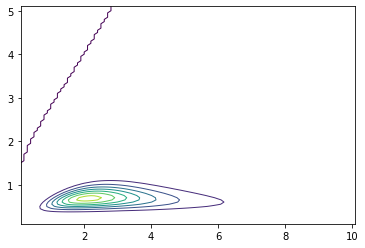

In [7]:
posterior = update_weibull(prior, data)
plot_contour(posterior)